In [21]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def calc_normalMap(depth_map):
    """calculate normal map from depth map

    Args:
        depth_map (ndarray): depth map

    Returns:
        ndarray: normal map
    """
    d_im = depth_map.astype("float64")
    zy, zx = np.gradient(d_im)  
    # You may also consider using Sobel to get a joint Gaussian smoothing and differentation
    # to reduce noise
    #zx = cv2.Sobel(d_im, cv2.CV_64F, 1, 0, ksize=5)     
    #zy = cv2.Sobel(d_im, cv2.CV_64F, 0, 1, ksize=5)

    normal = np.dstack((-zx, -zy, np.ones_like(d_im)))
    n = np.linalg.norm(normal, axis=2)
    normal[:, :, 0] /= n
    normal[:, :, 1] /= n
    normal[:, :, 2] /= n

    # offset and rescale values to be in 0-255
    normal += 1
    normal /= 2
    # if show, comment
    normal *= 255
    # cv2.imwrite("normal.png", normal[:, :, ::-1])
    return normal[:,:,::-1].copy()


In [27]:
path = '/home/rz/data/denoise/BU3DFE/depth_hq/mesh/F0001_AN01WH.png'
# path = '/home/rz/data/lock3dface/dataset_1028_new/train_set/001_Kinect_FE_1DEPTH/01_depth_normal.png'
# hq_img = cv.imread(path, flags=cv.IMREAD_UNCHANGED)[:,:,0]
hq_img = cv.imread(path)

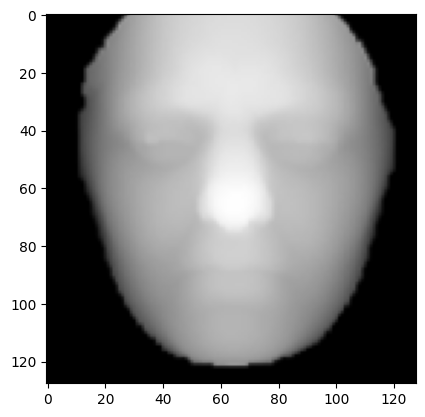

In [28]:
plt.imshow(hq_img, cmap='gray')

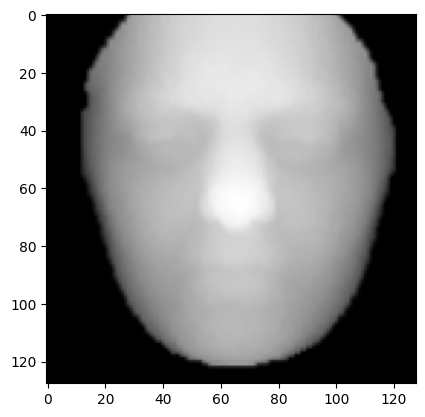

In [29]:
path = '/home/rz/data/denoise/BU3DFE/depth_lq/mesh/F0001_AN01WH.png'
lq_img = cv.imread(path)
plt.imshow(lq_img)

In [30]:
lr_lq_img = cv.resize(hq_img, (32, 32))

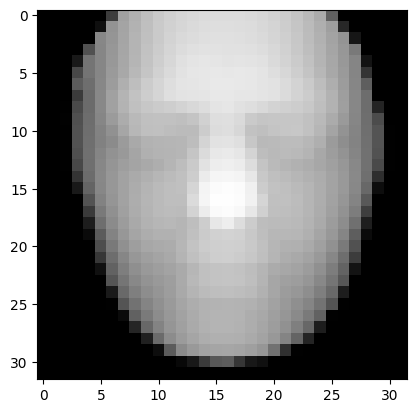

In [31]:
plt.imshow(lr_lq_img, cmap='gray')

In [33]:
# lr_lq_img = cv.cvtColor(lr_lq_img, cv.COLOR_GRAY2BGR)
# lr_lq_img.shape

In [34]:
cv.imwrite('./input.png', lr_lq_img)

True

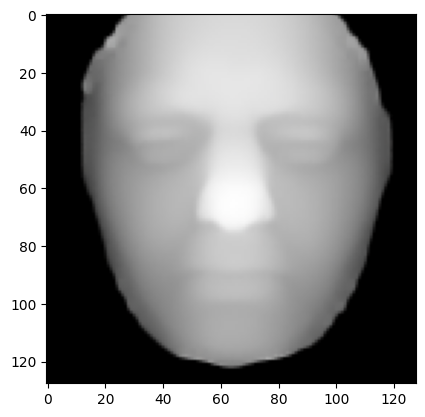

In [35]:
path = './output.png'
sr_img = cv.imread(path)
plt.imshow(sr_img)

In [41]:
normal = calc_normalMap(lr_lq_img[:,:,0])

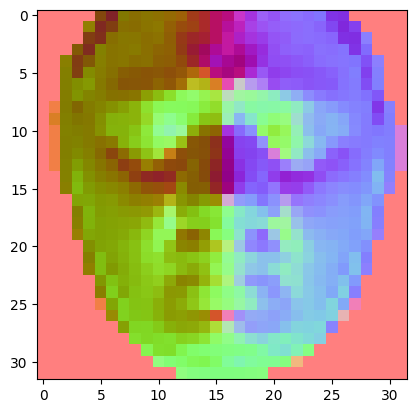

In [42]:
plt.imshow(normal.astype(np.uint8))